# Part 3: Image Classification Convolutional Neural Network

---

## Notebook Summary

This notebook explores our second model in which satellite images are classified to identify whether an image has or has not experienced a wildfire. This second model assumes that wildfire areas exhibit many similar terrestrial characteristics to areas prone to drought, such as drier vegetation and soils as well as potentially sparser vegetation. If a convolutional nearual network model could be trained on wildfire and no wildfire satellite images, then a similar model coud be used on satellite images to predict drought. In this notebook, the reader will find:

* Data Collection Methods
* Image EDA & Preprocessing
* Baseline CNN Model
* Model Tuning & Production Model
* Notebook Conclusion

---

## Data Collection Methods

The following dataset was collected from a Kaggle Wildfire Prediction Dataset [source](https://www.kaggle.com/datasets/abdelghaniaaba/wildfire-prediction-dataset?select=train). The original dataset was compiled by the Kaggle contributor from Canada's government website, sourced from the government and municipalities of Quebec, which compiled images primarily from southern Quebec, dating back to 1976 [source](https://open.canada.ca/data/en/dataset/9d8f219c-4df0-4481-926f-8a2a532ca003). According to the Kaggle webpage, the wildfire images include those which contain greater than 0.01 acres burned. Upon cursory review of the images in both the "wildfire" and "nowildfire" classes, the "nowildfire" class contains images of both forested or green area as well as images of urban landscapes and human settlements, albeit not exclusively.

Although the original Kaggle data contains three separate train, test, and validation datasets, we have downloaded only the train dataset since it contains 30,250 satellite images in total, of which 15,750 are classified as "wildfire" (\~52%) and 14,500 are classified as "nowildfire" (\~48%). The train dataset will be read into this notebook and then split into train and test datasets for training and evaluating our image classification CNN.

In the subsequent section, we shall read in our image data and begin preprocessing any images, as necessary.

---

## Image EDA & Preprocessing

In this section, we will begin reading in the dataset and then conducting any requisite cleaning of the data and preprocessing to make our models train and fit correctly. We will begin by importing the requisite libraries and using the image_dataset_from_directory module to create a train/test split and preprocess data.

In [14]:
# these four lines of code were adapted from https://machinelearningmastery.com/reproducible-results-neural-networks-keras/
# this code is intended to make results reproducible by seeding the random number generator
from numpy.random import seed
seed(1)
from tensorflow.keras.utils import set_random_seed
set_random_seed(2)

In [15]:
# import requisite libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from tensorflow.keras.utils import image_dataset_from_directory, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.callbacks import EarlyStopping

In [16]:
# create empty list for names of nowildfire images
nowildfire_arrays = []
# define filepath for nowildfire images
nowildfire_path = '../data/train/nowildfire/'

# convert each image to normalized array and store
for file in os.listdir(nowildfire_path):
    try:
        # target_size automatically resizes each img on import
        nowildfire_img = load_img(nowildfire_path + file, target_size=(350, 350))
        nowildfire_arr = img_to_array(nowildfire_img) / 255
        nowildfire_arrays.append(nowildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(nowildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
14499 pictures converted.


In [17]:
# create empty list for names of wildfire images
wildfire_arrays = []
# define filepath for wildfire images
wildfire_path = '../data/train/wildfire/'

# convert each image to normalized array and store
for file in os.listdir(wildfire_path):
    try:
        # target_size automatically resizes each img on import
        wildfire_img = load_img(wildfire_path + file, target_size=(350, 350))
        wildfire_arr = img_to_array(wildfire_img) / 255
        wildfire_arrays.append(wildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(wildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
15750 pictures converted.


In [18]:
len(nowildfire_arrays)

14499

In [19]:
nowildfire_arrays[0]

array([[[0.7411765 , 0.74509805, 0.7137255 ],
        [0.8392157 , 0.84313726, 0.8117647 ],
        [0.65882355, 0.6627451 , 0.6313726 ],
        ...,
        [0.7647059 , 0.75686276, 0.70980394],
        [0.7607843 , 0.7529412 , 0.7058824 ],
        [0.75686276, 0.7490196 , 0.7019608 ]],

       [[0.7411765 , 0.74509805, 0.7137255 ],
        [0.8352941 , 0.8392157 , 0.80784315],
        [0.65882355, 0.6627451 , 0.6313726 ],
        ...,
        [0.7647059 , 0.75686276, 0.70980394],
        [0.7607843 , 0.7529412 , 0.7058824 ],
        [0.75686276, 0.7490196 , 0.7019608 ]],

       [[0.7411765 , 0.74509805, 0.7137255 ],
        [0.83137256, 0.8352941 , 0.8039216 ],
        [0.654902  , 0.65882355, 0.627451  ],
        ...,
        [0.7647059 , 0.75686276, 0.70980394],
        [0.75686276, 0.7490196 , 0.7019608 ],
        [0.75686276, 0.7490196 , 0.7019608 ]],

       ...,

       [[0.23137255, 0.2627451 , 0.27450982],
        [0.23529412, 0.26666668, 0.2784314 ],
        [0.22745098, 0

In [20]:
nowildfire_arrays[0].shape

(350, 350, 3)

In [21]:
nowildfire_arrays[0].size

367500

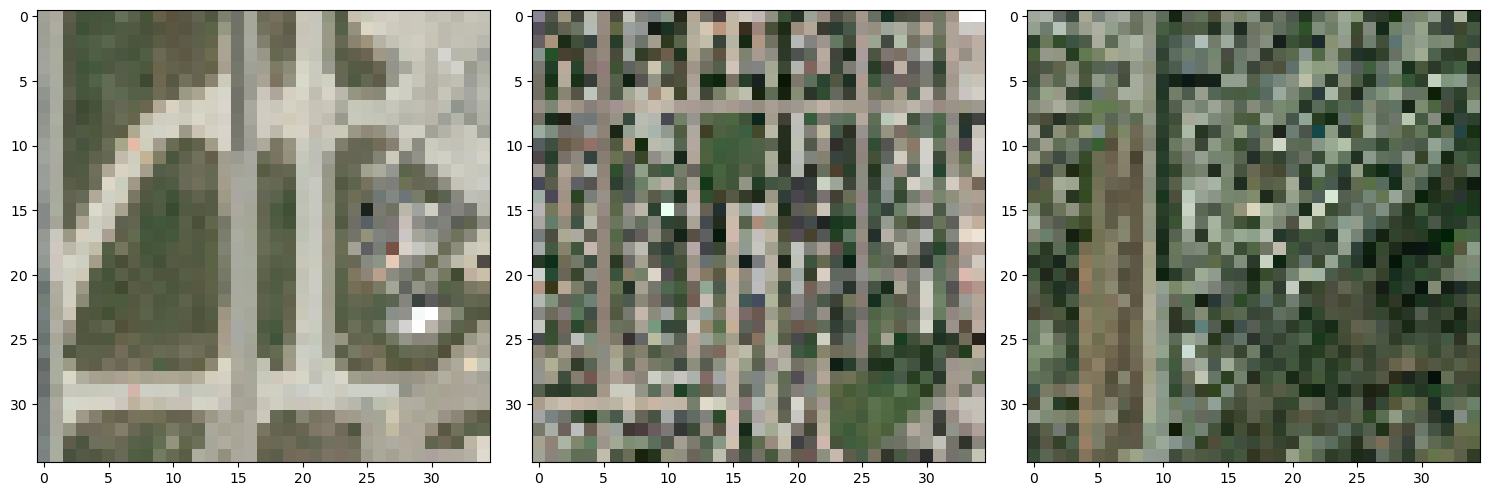

In [92]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(nowildfire_arrays[0])
ax2.imshow(nowildfire_arrays[1])
ax3.imshow(nowildfire_arrays[2])
plt.tight_layout()
plt.savefig('../images/no_wildfire.png');

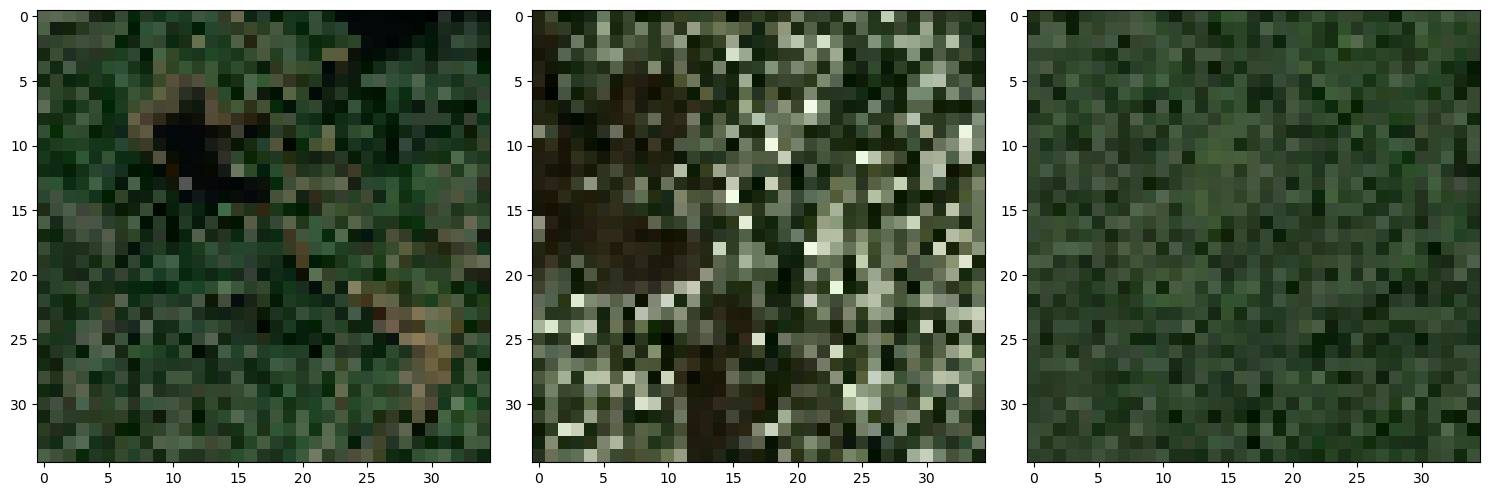

In [93]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(wildfire_arrays[0])
ax2.imshow(wildfire_arrays[1])
ax3.imshow(wildfire_arrays[2])
plt.tight_layout()
plt.savefig('../images/wildfire.png');

The first thing that we notice is that in just this small sample of the "nowildfire" images, they contain images with the built environment as well as natural environment. There are also images representing pastoral and rural areas in the "nowildfire" class which are not seen here. In contrast, the "wildfire" class of images includes images which appear to be heavily forested, including a mixture of images in whih the proportion of barren landscape is varied.

We can also see from a cursory peek into the list of arrays representing the "nowildfire" images that the arrays were loaded into the shape of a three-dimensional array of 350 x 350 x 3. The 350 x 350 represents the original size od the images in terms of the absolute number of pixels. The third dimension, 3, represents the three color channels available to each pixel in red, green, or blue. The values in the three-dimensional array represent the intensity of each channel in each pixel on a normalized scale of 0 to 1 instead of the typical 0 to 255 commonly used.

For the purposes of our modeling and our available computing power for our CNN, we will be resizing the image to 35 x 35 pixels but keep the three-channel RGB dimension and explore how the images compare in both classes on pixel intensity.

In [24]:
# create empty list for names of nowildfire images
nowildfire_arrays = []
# define filepath for nowildfire images
nowildfire_path = '../data/train/nowildfire/'

# convert each image to normalized array and store
for file in os.listdir(nowildfire_path):
    try:
        # target_size automatically resizes each img on import
        nowildfire_img = load_img(nowildfire_path + file, target_size=(35, 35))
        nowildfire_arr = img_to_array(nowildfire_img) / 255
        nowildfire_arrays.append(nowildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(nowildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
14499 pictures converted.


In [25]:
# create empty list for names of wildfire images
wildfire_arrays = []
# define filepath for wildfire images
wildfire_path = '../data/train/wildfire/'

# convert each image to normalized array and store
for file in os.listdir(wildfire_path):
    try:
        # target_size automatically resizes each img on import
        wildfire_img = load_img(wildfire_path + file, target_size=(35, 35))
        wildfire_arr = img_to_array(wildfire_img) / 255
        wildfire_arrays.append(wildfire_arr)
    except:
        print(f'Error for file: {file}')

print(f'{len(wildfire_arrays)} pictures converted.')

Error for file: .ipynb_checkpoints
15750 pictures converted.


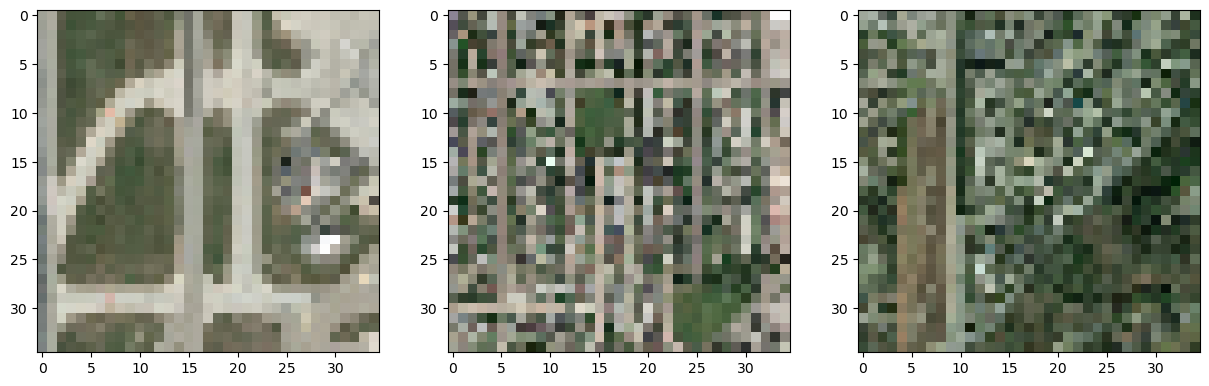

In [26]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(nowildfire_arrays[0])
ax2.imshow(nowildfire_arrays[1])
ax3.imshow(nowildfire_arrays[2]);

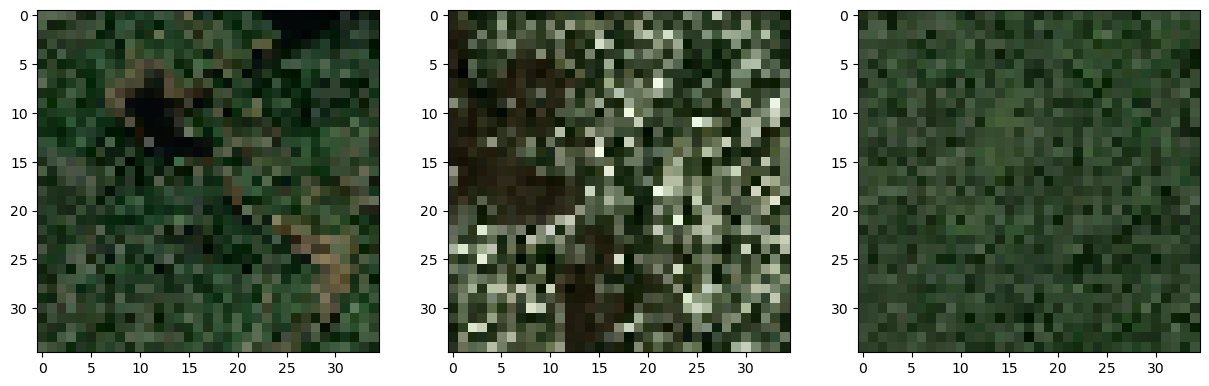

In [27]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15, 12))
ax1.imshow(wildfire_arrays[0])
ax2.imshow(wildfire_arrays[1])
ax3.imshow(wildfire_arrays[2]);

In comparison to our original images, there is clearly a strong difference in the resolution of our images. We will explore in our baseline model whether we can still predict the class accurately given some of the constraints of our computing power. For now, we will continue with exploring the pixel intensity of our images.

In [28]:
# flattens each three-dimensional image array into one dimension
nowf_flat_array = [i.ravel() for i in nowildfire_arrays]

nowf_flat_array

[array([0.627451  , 0.63529414, 0.5921569 , ..., 0.8784314 , 0.85490197,
        0.80784315], dtype=float32),
 array([0.54509807, 0.5176471 , 0.5803922 , ..., 0.76862746, 0.77254903,
        0.70980394], dtype=float32),
 array([0.627451  , 0.65882355, 0.60784316, ..., 0.1882353 , 0.23529412,
        0.14117648], dtype=float32),
 array([0.41960785, 0.4392157 , 0.3529412 , ..., 0.6039216 , 0.6117647 ,
        0.5294118 ], dtype=float32),
 array([0.4117647 , 0.3882353 , 0.33333334, ..., 0.46666667, 0.45882353,
        0.21960784], dtype=float32),
 array([0.36078432, 0.40784314, 0.32941177, ..., 0.6039216 , 0.5921569 ,
        0.53333336], dtype=float32),
 array([0.11764706, 0.22745098, 0.12941177, ..., 0.2       , 0.25882354,
        0.18431373], dtype=float32),
 array([0.14117648, 0.21176471, 0.16470589, ..., 0.32941177, 0.3254902 ,
        0.31764707], dtype=float32),
 array([0.16078432, 0.23529412, 0.14901961, ..., 0.4745098 , 0.48235294,
        0.42745098], dtype=float32),
 array([0.

In [29]:
# creates a new df with every three columns representing RGB channels for each pixel
nowildfire_df = pd.DataFrame(nowf_flat_array)

In [30]:
nowildfire_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674
0,0.627451,0.635294,0.592157,0.670588,0.662745,0.615686,0.360784,0.364706,0.294118,0.270588,...,0.615686,0.690196,0.666667,0.619608,0.705882,0.690196,0.643137,0.878431,0.854902,0.807843
1,0.545098,0.517647,0.580392,0.325490,0.337255,0.301961,0.600000,0.584314,0.486275,0.266667,...,0.588235,0.458824,0.447059,0.427451,0.447059,0.470588,0.423529,0.768627,0.772549,0.709804
2,0.627451,0.658824,0.607843,0.654902,0.694118,0.650980,0.384314,0.411765,0.384314,0.223529,...,0.290196,0.431373,0.447059,0.317647,0.360784,0.376471,0.286275,0.188235,0.235294,0.141176
3,0.419608,0.439216,0.352941,0.321569,0.352941,0.294118,0.160784,0.160784,0.129412,0.701961,...,0.368627,0.231373,0.258824,0.231373,0.568627,0.568627,0.521569,0.603922,0.611765,0.529412
4,0.411765,0.388235,0.333333,0.415686,0.403922,0.376471,0.458824,0.431373,0.368627,0.490196,...,0.560784,0.486275,0.450980,0.384314,0.419608,0.400000,0.250980,0.466667,0.458824,0.219608


In [31]:
nowildfire_df.shape[1]

3675

In [32]:
# flattens each three-dimensional image array into one dimension
wf_flat_array = [i.ravel() for i in wildfire_arrays]

wf_flat_array

[array([0.34509805, 0.39215687, 0.3137255 , ..., 0.05098039, 0.15294118,
        0.05490196], dtype=float32),
 array([0.13333334, 0.14117648, 0.05882353, ..., 0.07843138, 0.13725491,
        0.05490196], dtype=float32),
 array([0.13333334, 0.19607843, 0.09411765, ..., 0.23137255, 0.32156864,
        0.21960784], dtype=float32),
 array([0.30588236, 0.37254903, 0.24705882, ..., 0.25882354, 0.3372549 ,
        0.22745098], dtype=float32),
 array([0.15294118, 0.24313726, 0.14117648, ..., 0.14901961, 0.26666668,
        0.11764706], dtype=float32),
 array([0.14509805, 0.2627451 , 0.12156863, ..., 0.10980392, 0.20392157,
        0.07843138], dtype=float32),
 array([0.16078432, 0.24705882, 0.09803922, ..., 0.13333334, 0.1882353 ,
        0.09019608], dtype=float32),
 array([0.2509804 , 0.34117648, 0.22745098, ..., 0.21568628, 0.28627452,
        0.18431373], dtype=float32),
 array([0.13725491, 0.27058825, 0.1254902 , ..., 0.45490196, 0.5254902 ,
        0.36862746], dtype=float32),
 array([0.

In [33]:
# creates a new df with every three columns representing RGB channels for each pixel
wildfire_df = pd.DataFrame(wf_flat_array)

In [34]:
wildfire_df.head()

,0,1,2,3,4,5,6,7,8,9,...,3665,3666,3667,3668,3669,3670,3671,3672,3673,3674
0,0.345098,0.392157,0.313726,0.352941,0.411765,0.321569,0.313726,0.384314,0.290196,0.290196,...,0.278431,0.145098,0.274510,0.160784,0.141176,0.207843,0.133333,0.050980,0.152941,0.054902
1,0.133333,0.141176,0.058824,0.262745,0.298039,0.192157,0.023529,0.094118,0.007843,0.054902,...,0.427451,0.270588,0.317647,0.223529,0.325490,0.396078,0.294118,0.078431,0.137255,0.054902
2,0.133333,0.196078,0.094118,0.211765,0.274510,0.168627,0.101961,0.152941,0.074510,0.043137,...,0.172549,0.215686,0.305882,0.203922,0.062745,0.164706,0.050980,0.231373,0.321569,0.219608
3,0.305882,0.372549,0.247059,0.317647,0.376471,0.247059,0.329412,0.419608,0.254902,0.286275,...,0.235294,0.270588,0.349020,0.239216,0.266667,0.345098,0.235294,0.258824,0.337255,0.227451
4,0.152941,0.243137,0.141176,0.188235,0.278431,0.176471,0.133333,0.219608,0.129412,0.192157,...,0.137255,0.200000,0.317647,0.176471,0.094118,0.219608,0.066667,0.149020,0.266667,0.117647


In [35]:
wildfire_df.shape[1]

3675

In the preceding cells of code, we have taken our list of three dimensional arrays and flattened them into one dimension and then stored them into two dataframes of "nowildfire" and "wildfire" with each row representing an individual image.

Knowing that every third value in a row represents the same RGB channel, we can define a function which accepts the arguments of one of our dataframes and the first index for that channel (0 for red, 1 for green, and 2 for blue) and returns a list of the average pixel intensities for an individual color channel for each image. The function is defined below and then we have called the function for all three RGB channels in our "nowildfire" dataframe and then visualized the average pixel intensity.

In [36]:
def pxl_intensity(df, rgb):
    avgs = []
    for i in range(df.shape[0]):
        total = 0
        count = 0
        for j in range(rgb, df.shape[1], 3):
            total += df.iloc[i, j]
            count += 1
        avg = total / count
        avgs.append(avg)
    return avgs

In [37]:
nowf_red_means = pxl_intensity(nowildfire_df, 0)

In [38]:
nowf_green_means = pxl_intensity(nowildfire_df, 1)

In [39]:
nowf_blue_means = pxl_intensity(nowildfire_df, 2)

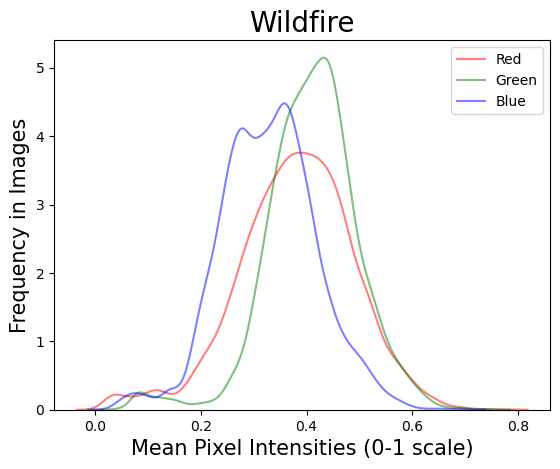

In [40]:
# create a histogram of all three channels of mean colored pixel intensities
sns.kdeplot(nowf_red_means, alpha = 0.5, color = 'red')
sns.kdeplot(nowf_green_means, alpha = 0.5, color = 'green')
sns.kdeplot(nowf_blue_means, alpha = 0.5, color = 'blue')
plt.xlabel('Mean Pixel Intensities (0-1 scale)', fontsize = 15)
plt.ylabel('Frequency in Images', fontsize = 15)
plt.title('Wildfire', fontsize = 20)
plt.legend(labels = ['Red', 'Green', 'Blue']);

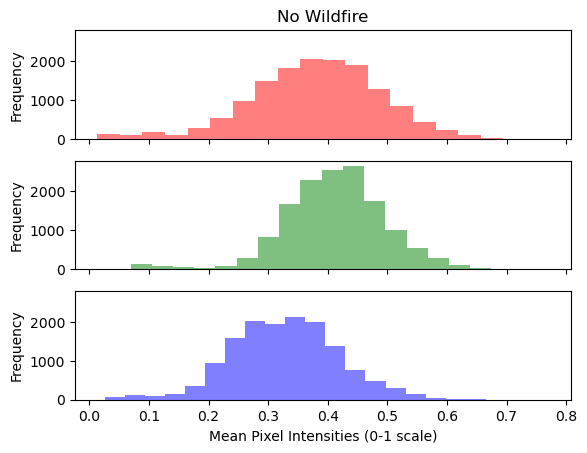

In [41]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey = True)

plt.subplot(3,1,1)
plt.hist(nowf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.ylabel('Frequency')
plt.title('No Wildfire')

plt.subplot(3,1,2)
plt.hist(nowf_green_means, bins = 20, alpha = 0.5, color = 'green')
plt.ylabel('Frequency')

plt.subplot(3,1,3)
plt.hist(nowf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.ylabel('Frequency')
plt.xlabel('Mean Pixel Intensities (0-1 scale)');

In this first visualization, we can see how all three color channels are distributed across the no wildfire images on average. The second visualization showns all three color channels separated for better comparison. All three colors' average pixel intensities per image appear to be relatively normally distributed with green appearing to have the highest mean around 0.43, followed by red at approximately 0.38 with blue trailing around 0.33. Additionally, the green channel appears to have slightly less variability than its red or blue counterparts for which the mean pixel intensity appears a bit more spread out.

Let's compare whether we see a similar or different pattern with our "wildfire" images as a class.

In [42]:
wf_red_means = pxl_intensity(wildfire_df, 0)

In [43]:
wf_green_means = pxl_intensity(wildfire_df, 1)

In [44]:
wf_blue_means = pxl_intensity(wildfire_df, 2)

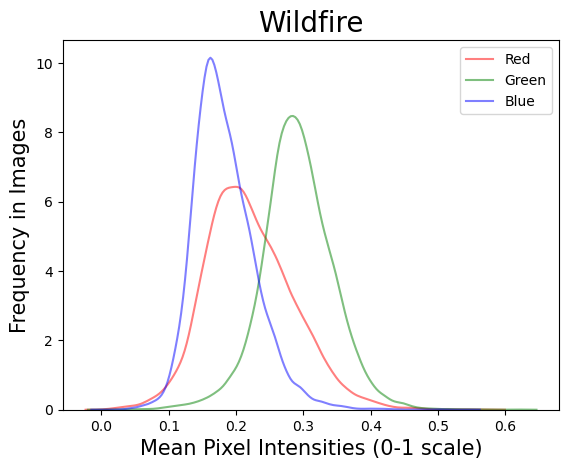

In [45]:
# create a histogram of all three channels of mean colored pixel intensities
sns.kdeplot(wf_red_means, alpha = 0.5, color = 'red')
sns.kdeplot(wf_green_means, alpha = 0.5, color = 'green')
sns.kdeplot(wf_blue_means, alpha = 0.5, color = 'blue')
plt.xlabel('Mean Pixel Intensities (0-1 scale)', fontsize = 15)
plt.ylabel('Frequency in Images', fontsize = 15)
plt.title('Wildfire', fontsize = 20)
plt.legend(labels = ['Red', 'Green', 'Blue']);

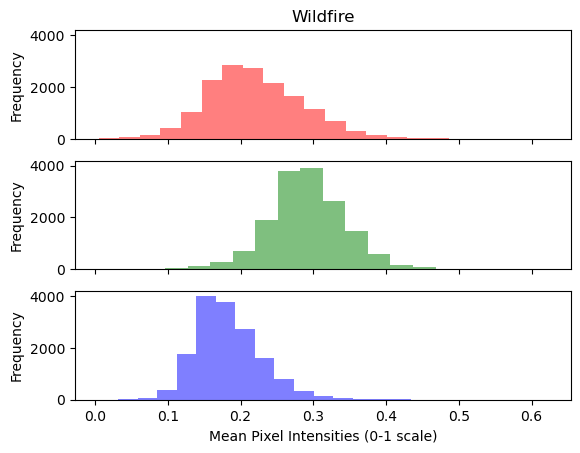

In [46]:
fig, ax = plt.subplots(3, 1, sharex=True, sharey = True)

plt.subplot(3,1,1)
plt.hist(wf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.ylabel('Frequency')
plt.title('Wildfire')

plt.subplot(3,1,2)
plt.hist(wf_green_means, bins = 20, alpha = 0.5, color = 'green')
plt.ylabel('Frequency')

plt.subplot(3,1,3)
plt.hist(wf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.ylabel('Frequency')
plt.xlabel('Mean Pixel Intensities (0-1 scale)');

In comparison to the no wildfire images, it appears that for all three color channels in the wildfire images, the mean pixel intensity of each is lower, with green occurring at about 0.29, red at roughly, 0.21, and blue at appproximately 0.18. Additionally, the distirbution of all three in the wildfire image appears to be much narrower as more of the values are closely bunches around the mean.

We shall now stack all of the histograms in a subplot for better comparison.

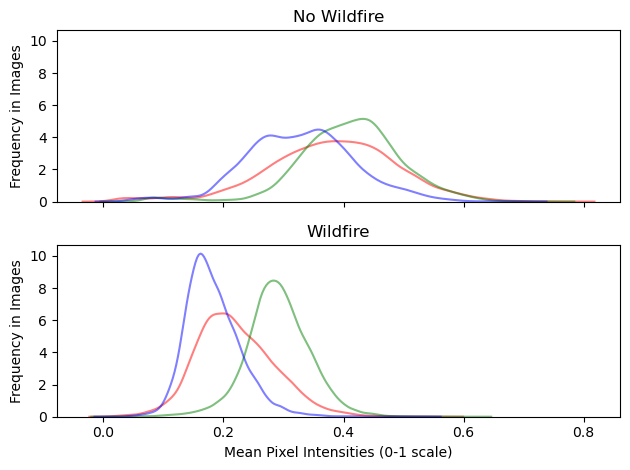

In [94]:
fig, ax = plt.subplots(2, 1, sharex=True, sharey = True)

plt.subplot(2,1,1)
sns.kdeplot(nowf_red_means, alpha = 0.5, color = 'red')
sns.kdeplot(nowf_green_means, alpha = 0.5, color = 'green')
sns.kdeplot(nowf_blue_means, alpha = 0.5, color = 'blue')
plt.ylabel('Frequency in Images')
plt.title('No Wildfire')

plt.subplot(2,1,2)
sns.kdeplot(wf_red_means, alpha = 0.5, color = 'red')
sns.kdeplot(wf_green_means, alpha = 0.5, color = 'green')
sns.kdeplot(wf_blue_means, alpha = 0.5, color = 'blue')
plt.ylabel('Frequency in Images')
plt.title('Wildfire')
plt.xlabel('Mean Pixel Intensities (0-1 scale)')
plt.tight_layout()
plt.savefig('../images/pxl_kde_intensity.png');

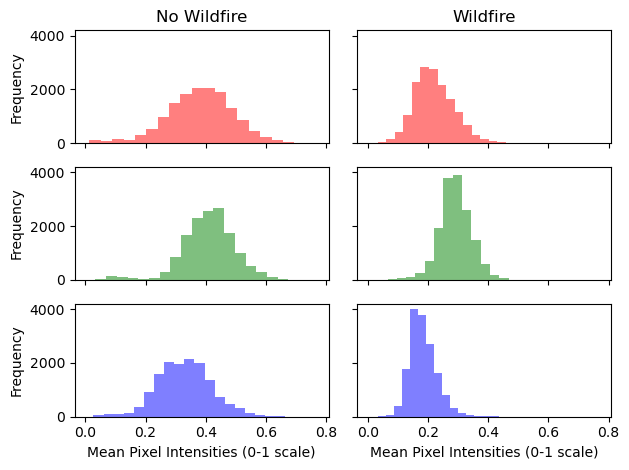

In [95]:
fig, ax = plt.subplots(3, 2, sharex=True, sharey = True)

plt.subplot(3,2,1)
plt.hist(nowf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.ylabel('Frequency')
plt.title('No Wildfire')

plt.subplot(3,2,2)
plt.hist(wf_red_means, bins = 20, alpha = 0.5, color = 'red')
plt.title('Wildfire')

plt.subplot(3,2,3)
plt.hist(nowf_green_means, bins = 20, alpha = 0.5, color = 'green')
plt.ylabel('Frequency')

plt.subplot(3,2,4)
plt.hist(wf_green_means, bins = 20, alpha = 0.5, color = 'green')

plt.subplot(3,2,5)
plt.hist(nowf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.ylabel('Frequency')
plt.xlabel('Mean Pixel Intensities (0-1 scale)')

plt.subplot(3,2,6)
plt.hist(wf_blue_means, bins = 20, alpha = 0.5, color = 'blue')
plt.xlabel('Mean Pixel Intensities (0-1 scale)')
plt.tight_layout()
plt.savefig('../images/pxl_hist_intensity.png');

Looking at our mean color channel pixel intensities in both classes, we can instantly see that all three color channels in the wildfire images tend to have a lower pixel intensity on average than the no wildfire image class. This gross difference in mean intensity across all three color channels indicates that there might be a stark difference in brightness of the images with wildfire images being darker than no wildfire images.

Next, we will conduct a train/test split and finish up any data cleaning before instantiating our CNN model. For the sake of trying to preserve a bit more of our images' original resolution, we will load the image data at 20% instead of 10% the original image size. For EDA, conducting a pixel intensity analysis at 20% scaling would have be unwieldy, but our CNN can handle a 70 x 70 x 3 three-dimensional array, given our current computational power.

In [49]:
# General Assembly instructor, Alanna Besaw, recommended investigating image_dataset_from_directory module for manipulating this dataset
# original image sizes are 350 x 350 pixels
# create a training set of the data representing 75% of the images
img_train = image_dataset_from_directory('../data/train/',  
                                         validation_split = 0.25,
                                         image_size = (70, 70), # resized to exactly one fifth in size
                                         subset = 'training', 
                                         seed = 42)

# create a test set of the representing 25% of the images
img_test = image_dataset_from_directory('../data/train/', 
                                         validation_split = 0.25, 
                                         image_size = (70, 70),  # resized to exactly one fifth in size
                                         subset = 'validation', 
                                         seed = 42)

Found 30252 files belonging to 2 classes.
Using 22689 files for training.
Found 30252 files belonging to 2 classes.
Using 7563 files for validation.


In [50]:
# check the datatype of the train set
img_train

<_BatchDataset element_spec=(TensorSpec(shape=(None, 70, 70, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [51]:
# check the datatype of the test set
img_test

<_BatchDataset element_spec=(TensorSpec(shape=(None, 70, 70, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

We now have the full image dataset in the form of a \_BatchDataset data type and split into bothtrain and test sets. Upon trying to train our first CNN model, it kept throwing an error which was indicating a corrupted image file, so we searched Stack Overflow for a method to make a list of all the files in a directory. The code is attributed and executed below.

In [52]:
# this block of code was adapted from a Stack Overflow post at https://stackoverflow.com/questions/3207219/how-do-i-list-all-files-of-a-directory
directory = '../data/train/nowildfire'

# Get a list of all items (files and directories) in the directory
all_items = os.listdir(directory)

# Filter out only the file names from the list
file_names = [item for item in all_items if os.path.isfile(os.path.join(directory, item))]

After creating the list of files in the directory, we needed to iterate through all the files and identify which of the files might be corrupted and remove it from the directory. The following block of code is taken directly from Stack Overflow as well. The authors here have added comments to make sense of the code and how it identifies and removes a corrupted file.

In [53]:
# this block of code was taken from a Stack Overflow post at https://stackoverflow.com/questions/62586443/tensorflow-error-when-trying-transfer-learning-invalid-jpeg-data-or-crop-windo

# imports required to read in and unpack files
from struct import unpack
import os

# maps parts of image onto markers
marker_mapping = {
    0xffd8: "Start of Image",
    0xffe0: "Application Default Header",
    0xffdb: "Quantization Table",
    0xffc0: "Start of Frame",
    0xffc4: "Define Huffman Table",
    0xffda: "Start of Scan",
    0xffd9: "End of Image"
}

# establishes the JPEG class
class JPEG:
    # initiates an object within the class by opening an image file and reading it in
    def __init__(self, image_file):
        with open(image_file, 'rb') as f:
            self.img_data = f.read()
    
    # decodes an image by checking multiple markers to verify whether they are true
    def decode(self):
        data = self.img_data
        while(True):
            marker, = unpack(">H", data[0:2])
            # print(marker_mapping.get(marker))
            if marker == 0xffd8:
                data = data[2:]
            elif marker == 0xffd9:
                return
            elif marker == 0xffda:
                data = data[-2:]
            else:
                lenchunk, = unpack(">H", data[2:4])
                data = data[2+lenchunk:]            
            if len(data)==0:
                break        

# creates an empty list of bad images (corrupted data)
bads = []

# loops through the list of file names in the nowildfire directory
# tries to decode the image to verify it is an uncorrupted jpg
# if it fails to decode, adds corrupted jpg file to the bads list
for img in file_names:
  image = os.path.join(directory, img)
  image = JPEG(image) 
  try:
    image.decode()   
  except:
    bads.append(img)

# loops through the bads list and removes corrupted files from directory
for name in bads:
  os.remove(os.path.join(directory,name))

In [54]:
# in the first execution of this code, only one file was added to the list but has since been removed
bads

[]

At this point, the corrupted image file has been removed from the dataset, so the data are sufficiently cleaned for us to begin instantiating our model. However, since our CNN model will rely on our train/test split from the image_dataset_from_directory module, which is not the same as our list of arrays used during initial exploratory data analysis. The \_BatchDatasets of both the train and test set were already resized when we loaded the images but they were not yet normalized. Therefore, in the instantiation of this and all subsequent models, we will embed the preprocessing of batch normalization into the model itself. This method was taken from a tensorflow tutorial [source](https://www.tensorflow.org/tutorials/images/classification), and GA Instructor, Rowan Schaefer, directed the authors to this tutorial source.

In the next section, we shall instantiate our baseline CNN model.

---

## Baseline CNN Model

In this section, we will establish a simple baseline image classification convolutional neural network (CNN) with just a single input layer and an output layer. Before we do, it bears repeating that our null baseline accuracy score would be approximately 0.52 since 52% of the images are classified as wildfire images. Therefore, any baseline CNN model must perform better than 0.52 accuracy. We shall train our first model to see whether we can at a minimum outperform the null baseline accuracy score.

In [55]:
# instantiates sequential baseline model
model_base = Sequential()

# rescales 
model_base.add(Rescaling(1./255))

# make a convolutional layer with 16 filters and MaxPool the results
model_base.add(Conv2D(16, 3, activation='relu', input_shape=(70, 70, 3)))
model_base.add(MaxPooling2D(2))

# flattens the output and makes a predictions
model_base.add(Flatten())
model_base.add(Dense(1, activation='sigmoid'))

In [56]:
model_base.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [57]:
res_base = model_base.fit(
    img_train,
    validation_data=(img_test),
    batch_size=512,
    epochs=10
)

Epoch 1/10
710/710 [==============================] - 13s 18ms/step - loss: 0.2453 - acc: 0.9022 - val_loss: 0.2860 - val_acc: 0.8917
Epoch 2/10
710/710 [==============================] - 13s 18ms/step - loss: 0.1982 - acc: 0.9263 - val_loss: 0.1919 - val_acc: 0.9265
Epoch 3/10
710/710 [==============================] - 14s 19ms/step - loss: 0.1774 - acc: 0.9350 - val_loss: 0.1913 - val_acc: 0.9261
Epoch 4/10
710/710 [==============================] - 14s 19ms/step - loss: 0.1634 - acc: 0.9418 - val_loss: 0.2088 - val_acc: 0.9226
Epoch 5/10
710/710 [==============================] - 14s 20ms/step - loss: 0.1482 - acc: 0.9468 - val_loss: 0.1791 - val_acc: 0.9327
Epoch 6/10
710/710 [==============================] - 14s 20ms/step - loss: 0.1392 - acc: 0.9500 - val_loss: 0.2085 - val_acc: 0.9248
Epoch 7/10
710/710 [==============================] - 14s 20ms/step - loss: 0.1237 - acc: 0.9574 - val_loss: 0.2768 - val_acc: 0.9057
Epoch 8/10
710/710 [==============================] - 14s 20ms

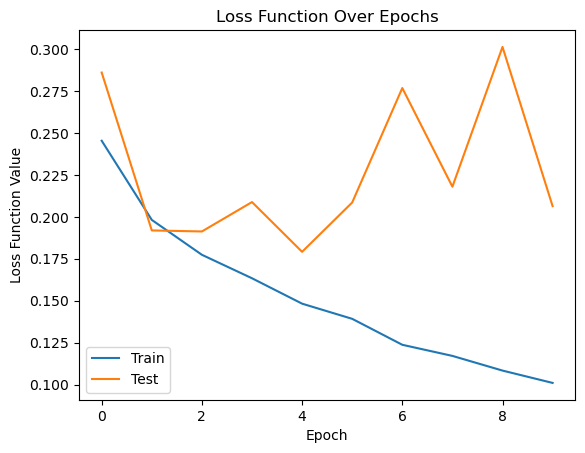

In [58]:
plt.plot(res_base.history['loss'], label = 'Train')
plt.plot(res_base.history['val_loss'], label = 'Test')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend();

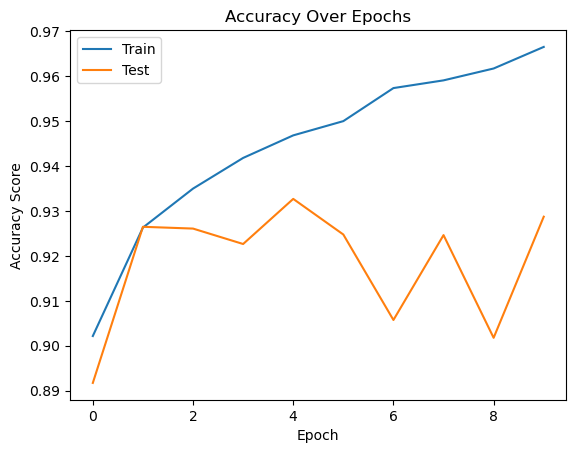

In [59]:
plt.plot(res_base.history['acc'], label = 'Train')
plt.plot(res_base.history['val_acc'], label = 'Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend();

Based on our initial baseline CNN model, we can see that the model has an approximately 0.93 test accuracy, indicating a very high test performance with a binary crossentropy loss test score of approximately 0.21. However, judging by our graphs of loss and accuracy across the epochs of fitting, we can see a wide difference between the train and test sets, indicating our baseline CNN model is very overfit. In the subsequent section, we shall model tune to regularize our CNN to minimize the loss function and evaluate our final production model's performance.

---

## Model Tuning & Production Model

In this section, we shall begin with our baseline CNN model which is already massively outperforming the null baseline accuracy and attempt to minimize the loss function through multiple model iterations. At each model iteration, we shall pause to evaluate performance and add more regularization methods to the subsequent models. We shall begin first by adding more hidden convolutional layers to our baseline model, one with 64 neurons and another with 128 neurons.

In [60]:
# instantiates sequential baseline model
model_1 = Sequential()

# rescales 
model_1.add(Rescaling(1./255))

# make a convolutional layer with 16 filters and MaxPool the results
model_1.add(Conv2D(16, 3, activation='relu', input_shape=(70, 70, 3)))
model_1.add(MaxPooling2D(2))

# adds another conv2D layer
model_1.add(Conv2D(64, 3, activation='relu'))
model_1.add(MaxPooling2D(2))

# adds another conv2D layer
model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions.
model_1.add(Flatten())
model_1.add(Dense(1, activation='sigmoid'))

In [61]:
model_1.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [62]:
res_1 = model_1.fit(
    img_train,
    validation_data=(img_test),
    batch_size=512,
    epochs=10
)

Epoch 1/10
710/710 [==============================] - 33s 47ms/step - loss: 0.2271 - acc: 0.9103 - val_loss: 0.1867 - val_acc: 0.9299
Epoch 2/10
710/710 [==============================] - 34s 48ms/step - loss: 0.1773 - acc: 0.9336 - val_loss: 0.2146 - val_acc: 0.9175
Epoch 3/10
710/710 [==============================] - 34s 47ms/step - loss: 0.1632 - acc: 0.9399 - val_loss: 0.1481 - val_acc: 0.9424
Epoch 4/10
710/710 [==============================] - 33s 47ms/step - loss: 0.1523 - acc: 0.9425 - val_loss: 0.2000 - val_acc: 0.9260
Epoch 5/10
710/710 [==============================] - 35s 48ms/step - loss: 0.1350 - acc: 0.9497 - val_loss: 0.1713 - val_acc: 0.9334
Epoch 6/10
710/710 [==============================] - 36s 51ms/step - loss: 0.1264 - acc: 0.9536 - val_loss: 0.1446 - val_acc: 0.9451
Epoch 7/10
710/710 [==============================] - 38s 53ms/step - loss: 0.1182 - acc: 0.9565 - val_loss: 0.2507 - val_acc: 0.8967
Epoch 8/10
710/710 [==============================] - 39s 54ms

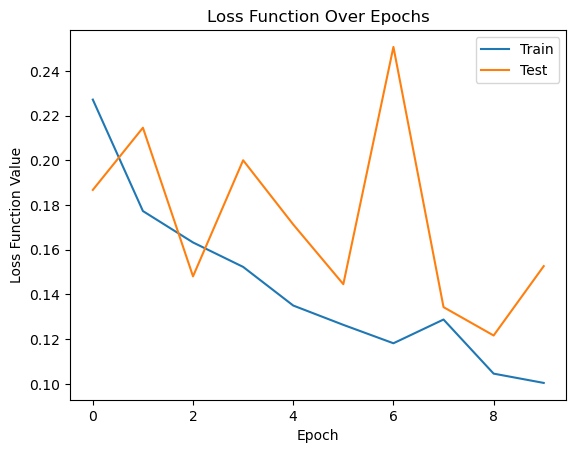

In [63]:
plt.plot(res_1.history['loss'], label = 'Train')
plt.plot(res_1.history['val_loss'], label = 'Test')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend();

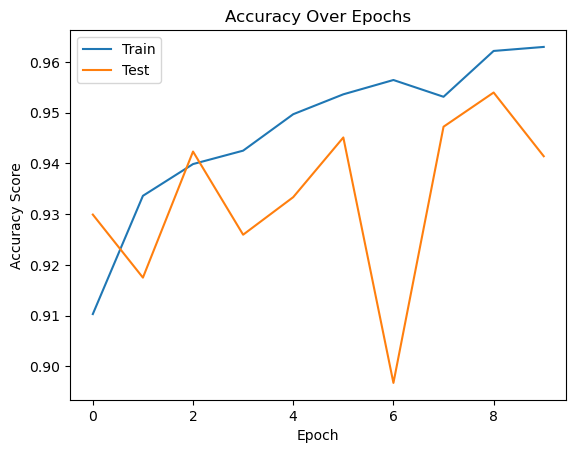

In [64]:
plt.plot(res_1.history['acc'], label = 'Train')
plt.plot(res_1.history['val_acc'], label = 'Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend();

In this Model 1, we can compare our loss and accuracy graphs here to that which we see in our baseline model. We notice immediately that Model 1 is somewhat already better fit than the baseline model, as both train and test graphs has closer values with the exception of a few epochs. The loss function's test value has also decreased from approximately 0.21 to 0.15 while the test accuracy score has increased from approximately 0.93 to 0.94, indicating better performance than the baseline CNN model.

For our next iteration in Model 2, we shall keep the hidden layers. We shall try an early stopping method to see if the number of epochs can be finished early. Here, we have chosen a patience level of 5, which may be too large given that we are only training the CNN model on 10 epochs in total given the computational demands of fitting a CNN. However, we suspect that any patience less than 5 might result in halting model training prematurely especially given the relatively small total number of epochs in the CNN.

In [65]:
# instantiates an early stop
es = EarlyStopping(patience = 5)

# instantiates sequential baseline model
model_2 = Sequential()

# rescales 
model_2.add(Rescaling(1./255))

# make a convolutional layer with 16 filters and MaxPool the results
model_2.add(Conv2D(16, 3, activation='relu', input_shape=(70, 70, 3)))
model_2.add(MaxPooling2D(2))

# adds another conv2D layer
model_2.add(Conv2D(64, 3, activation='relu'))
model_2.add(MaxPooling2D(2))

# adds another conv2D layer
model_2.add(Conv2D(128, 3, activation='relu'))
model_2.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions.
model_2.add(Flatten())
model_2.add(Dense(1, activation='sigmoid'))

In [66]:
model_2.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [67]:
res_2 = model_2.fit(
    img_train,
    validation_data=(img_test),
    callbacks = [es],
    batch_size=512,
    epochs=10
)

Epoch 1/10
710/710 [==============================] - 43s 60ms/step - loss: 0.2379 - acc: 0.9034 - val_loss: 0.1756 - val_acc: 0.9342
Epoch 2/10
710/710 [==============================] - 42s 59ms/step - loss: 0.1783 - acc: 0.9339 - val_loss: 0.1875 - val_acc: 0.9302
Epoch 3/10
710/710 [==============================] - 45s 63ms/step - loss: 0.1642 - acc: 0.9403 - val_loss: 0.1612 - val_acc: 0.9385
Epoch 4/10
710/710 [==============================] - 46s 64ms/step - loss: 0.1528 - acc: 0.9429 - val_loss: 0.1532 - val_acc: 0.9396
Epoch 5/10
710/710 [==============================] - 46s 64ms/step - loss: 0.1393 - acc: 0.9479 - val_loss: 0.1428 - val_acc: 0.9417
Epoch 6/10
710/710 [==============================] - 45s 64ms/step - loss: 0.1317 - acc: 0.9509 - val_loss: 0.1543 - val_acc: 0.9410
Epoch 7/10
710/710 [==============================] - 45s 63ms/step - loss: 0.1246 - acc: 0.9517 - val_loss: 0.1369 - val_acc: 0.9449
Epoch 8/10
710/710 [==============================] - 45s 63ms

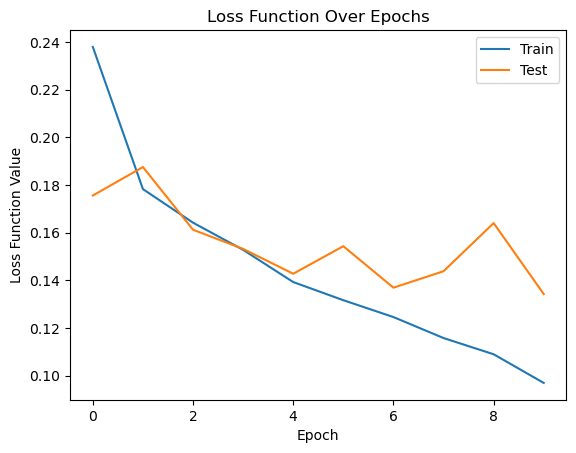

In [68]:
plt.plot(res_2.history['loss'], label = 'Train')
plt.plot(res_2.history['val_loss'], label = 'Test')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend();

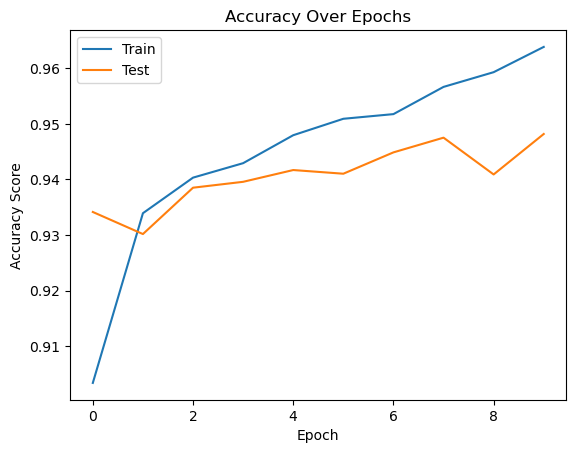

In [69]:
plt.plot(res_2.history['acc'], label = 'Train')
plt.plot(res_2.history['val_acc'], label = 'Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend();

Although the early stopping method does not appear to have altered stopped the training early, there is a marked improvement in Model 2's performance in comparison to Model 1 as well as in comparison to the Baseline Model. We can see a loss function test value decrease down to approximately 0.13 while the test accuracy score increased to approximately 0.95. We shall keep the early stopping method in subsequent iterations just in case the other regularizing methods can be stopped early, so we might see an increase in model performance.

In Model 3, we shall add a Ridge regularization method to the input and hidden layers of our CNN model and evaluate the loss function and accuracy accordingly.

In [70]:
# instantiates an early stop
es = EarlyStopping(patience = 5)

# instantiates sequential baseline model
model_3 = Sequential()

# rescales 
model_3.add(Rescaling(1./255))

# make a convolutional layer with 16 filters and MaxPool the results
model_3.add(Conv2D(16, 3, 
                   activation='relu', 
                   input_shape=(70, 70, 3),
                   kernel_regularizer = l2(0.01)))
model_3.add(MaxPooling2D(2))

# adds another conv2D layer
model_3.add(Conv2D(64, 3, 
                   activation='relu',
                   kernel_regularizer = l2(0.01)))
model_3.add(MaxPooling2D(2))

# adds another conv2D layer
model_3.add(Conv2D(128, 3,
                   activation='relu',
                   kernel_regularizer = l2(0.01)))
model_3.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions.
model_3.add(Flatten())
model_3.add(Dense(1, activation='sigmoid'))

In [71]:
model_3.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [72]:
res_3 = model_3.fit(
    img_train,
    validation_data=(img_test),
    callbacks = [es],
    batch_size=512,
    epochs=10
)

Epoch 1/10
710/710 [==============================] - 59s 82ms/step - loss: 0.4069 - acc: 0.8884 - val_loss: 0.3480 - val_acc: 0.8992
Epoch 2/10
710/710 [==============================] - 60s 85ms/step - loss: 0.2862 - acc: 0.9131 - val_loss: 0.2933 - val_acc: 0.9067
Epoch 3/10
710/710 [==============================] - 57s 80ms/step - loss: 0.2622 - acc: 0.9183 - val_loss: 0.3000 - val_acc: 0.9007
Epoch 4/10
710/710 [==============================] - 63s 89ms/step - loss: 0.2505 - acc: 0.9189 - val_loss: 0.2782 - val_acc: 0.9048
Epoch 5/10
710/710 [==============================] - 56s 79ms/step - loss: 0.2448 - acc: 0.9204 - val_loss: 0.2454 - val_acc: 0.9174
Epoch 6/10
710/710 [==============================] - 58s 81ms/step - loss: 0.2335 - acc: 0.9231 - val_loss: 0.2338 - val_acc: 0.9209
Epoch 7/10
710/710 [==============================] - 55s 78ms/step - loss: 0.2273 - acc: 0.9247 - val_loss: 0.3348 - val_acc: 0.8805
Epoch 8/10
710/710 [==============================] - 52s 74ms

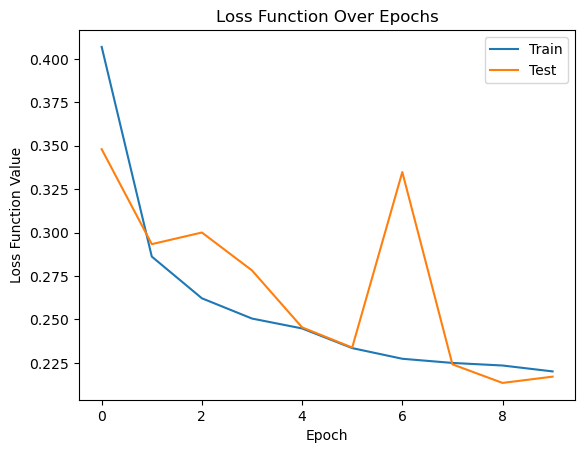

In [73]:
plt.plot(res_3.history['loss'], label = 'Train')
plt.plot(res_3.history['val_loss'], label = 'Test')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend();

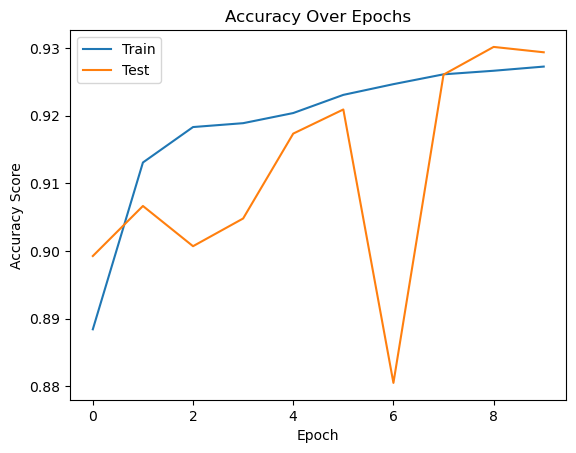

In [74]:
plt.plot(res_3.history['acc'], label = 'Train')
plt.plot(res_3.history['val_acc'], label = 'Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend();

In Model 3, we can see that there is somewhat of a dip in model performance. Overall, this model appears to be better fitted than Model 2 with the exception of the seventh epoch. This generally makes sense since the Ridge regularization is attempting to correct overfitting and may eliminate some of the CNN model's tendency to attend to variability in the training set. However, this appears to increase the final loss function's test value to approximatley 0.22 and decrease the final test accuracy score to approximately 0.93. This model is performing slightly worse than our baseline CNN. Therefore, in the next model iteration, we shall scrap the Ridge regularization.

In Model 4, we shall include a couple dropout layers in one final attempt to improve model performance.

In [75]:
# instantiates an early stop
es = EarlyStopping(patience = 5)

# instantiates sequential baseline model
model_4 = Sequential()

# rescales 
model_4.add(Rescaling(1./255))

# make a convolutional layer with 16 filters and MaxPool the results
model_4.add(Conv2D(16, 3, 
                   activation='relu', 
                   input_shape=(70, 70, 3)))
model_4.add(MaxPooling2D(2))

# adds a dropout layer
model_4.add(Dropout(0.1))

# adds another conv2D layer
model_4.add(Conv2D(64, 3, 
                   activation='relu'))
model_4.add(MaxPooling2D(2))

# adds a dropout layer
model_4.add(Dropout(0.25))

# adds another conv2D layer
model_4.add(Conv2D(128, 3,
                   activation='relu'))
model_4.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions.
model_4.add(Flatten())
model_4.add(Dense(1, activation='sigmoid'))

In [76]:
model_4.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [77]:
res_4 = model_4.fit(
    img_train,
    validation_data=(img_test),
    callbacks = [es],
    batch_size=512,
    epochs=10
)

Epoch 1/10
710/710 [==============================] - 55s 78ms/step - loss: 0.2302 - acc: 0.9070 - val_loss: 0.2268 - val_acc: 0.9176
Epoch 2/10
710/710 [==============================] - 47s 66ms/step - loss: 0.1805 - acc: 0.9330 - val_loss: 0.2585 - val_acc: 0.9032
Epoch 3/10
710/710 [==============================] - 47s 67ms/step - loss: 0.1653 - acc: 0.9381 - val_loss: 0.2285 - val_acc: 0.9109
Epoch 4/10
710/710 [==============================] - 47s 65ms/step - loss: 0.1650 - acc: 0.9392 - val_loss: 0.1621 - val_acc: 0.9340
Epoch 5/10
710/710 [==============================] - 46s 65ms/step - loss: 0.1468 - acc: 0.9460 - val_loss: 0.1377 - val_acc: 0.9461
Epoch 6/10
710/710 [==============================] - 46s 65ms/step - loss: 0.1377 - acc: 0.9496 - val_loss: 0.2126 - val_acc: 0.9121
Epoch 7/10
710/710 [==============================] - 47s 65ms/step - loss: 0.1338 - acc: 0.9507 - val_loss: 0.1380 - val_acc: 0.9454
Epoch 8/10
710/710 [==============================] - 47s 67ms

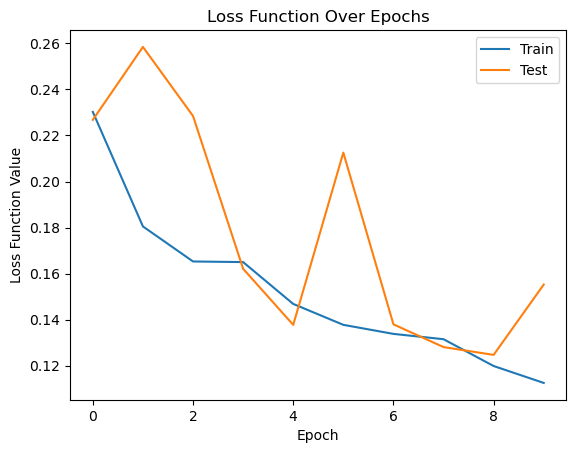

In [78]:
plt.plot(res_4.history['loss'], label = 'Train')
plt.plot(res_4.history['val_loss'], label = 'Test')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend();

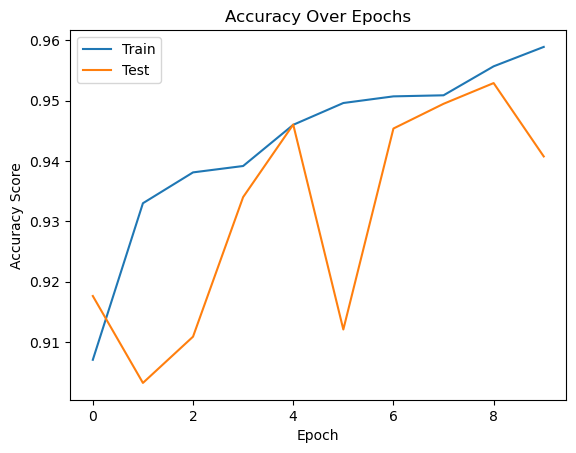

In [79]:
plt.plot(res_4.history['acc'], label = 'Train')
plt.plot(res_4.history['val_acc'], label = 'Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend();

In comparison to Model 3, Model 4 has shown some improvement in performance. The loss function's final test value is approximately 0.16 while the final test accuracy score is approximately 0.94. This does exceed not Model 2's performance with a lower loss function value and higher accuracy.

For our final production model, we shall retrain Model 2 as our best performing model. However, this time we shall allow the model to run for 25 epochs instead of merely 10 to see if this can maintain or improve performance.

In [85]:
# instantiates an early stop
es = EarlyStopping(patience = 5)

# instantiates sequential baseline model
model_prod = Sequential()

# rescales 
model_prod.add(Rescaling(1./255))

# make a convolutional layer with 16 filters and MaxPool the results
model_prod.add(Conv2D(16, 3, activation='relu', input_shape=(70, 70, 3)))
model_prod.add(MaxPooling2D(2))

# adds another conv2D layer
model_prod.add(Conv2D(64, 3, activation='relu'))
model_prod.add(MaxPooling2D(2))

# adds another conv2D layer
model_prod.add(Conv2D(128, 3, activation='relu'))
model_prod.add(MaxPooling2D(2))

# Finally, flatten the output and make a predictions.
model_prod.add(Flatten())
model_prod.add(Dense(1, activation='sigmoid'))

In [86]:
model_prod.compile(
    loss='binary_crossentropy', 
    optimizer='adam',
    metrics=['acc']
)

In [87]:
res_prod = model_prod.fit(
    img_train,
    validation_data=(img_test),
    callbacks = [es],
    batch_size=512,
    epochs=25
)

Epoch 1/25
710/710 [==============================] - 30s 42ms/step - loss: 0.2500 - acc: 0.8992 - val_loss: 0.2058 - val_acc: 0.9256
Epoch 2/25
710/710 [==============================] - 31s 44ms/step - loss: 0.1876 - acc: 0.9296 - val_loss: 0.1678 - val_acc: 0.9359
Epoch 3/25
710/710 [==============================] - 33s 47ms/step - loss: 0.1670 - acc: 0.9377 - val_loss: 0.1706 - val_acc: 0.9342
Epoch 4/25
710/710 [==============================] - 36s 50ms/step - loss: 0.1527 - acc: 0.9409 - val_loss: 0.1529 - val_acc: 0.9416
Epoch 5/25
710/710 [==============================] - 34s 47ms/step - loss: 0.1420 - acc: 0.9456 - val_loss: 0.2019 - val_acc: 0.9253
Epoch 6/25
710/710 [==============================] - 36s 50ms/step - loss: 0.1384 - acc: 0.9473 - val_loss: 0.1415 - val_acc: 0.9441
Epoch 7/25
710/710 [==============================] - 36s 51ms/step - loss: 0.1293 - acc: 0.9508 - val_loss: 0.1318 - val_acc: 0.9471
Epoch 8/25
710/710 [==============================] - 37s 52ms

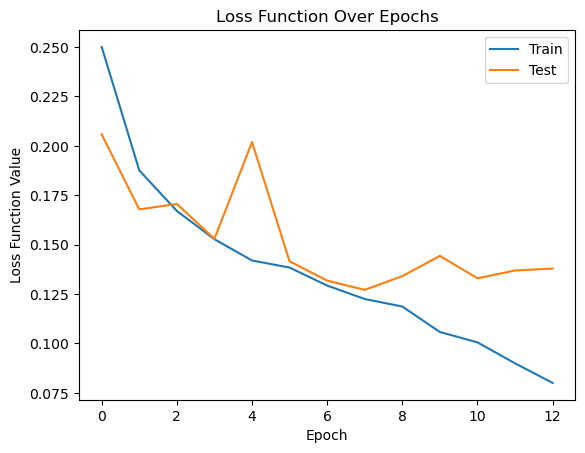

In [88]:
plt.plot(res_prod.history['loss'], label = 'Train')
plt.plot(res_prod.history['val_loss'], label = 'Test')
plt.title('Loss Function Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss Function Value')
plt.legend();

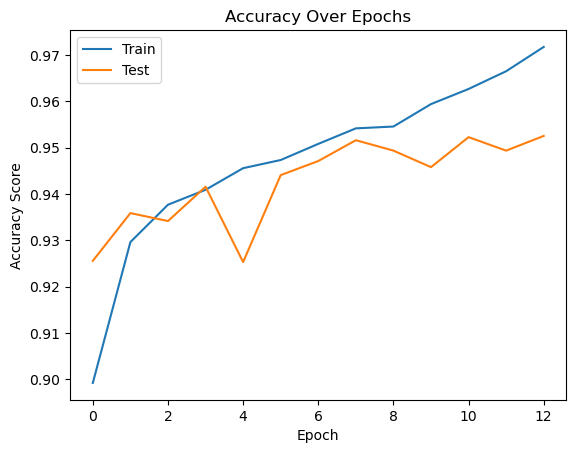

In [89]:
plt.plot(res_prod.history['acc'], label = 'Train')
plt.plot(res_prod.history['val_acc'], label = 'Test')
plt.title('Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy Score')
plt.legend();

Looking at our final production model, we appear to have a **minimized test value for our loss function 0.13** (marginally higher than Model 2) and **maximized test score for our accuracy at 0.95**. Interestingly enough, due to our early stopping, the final production model stopped training after 13 epochs, suggesting that we can reliably assume that our previous model iterations of 10 epochs may have been sufficient enough to train the previous models. We can also say that we have arrived at the following **final attributes of our image classification CNN production model**:

* Input Layer of 16 Nodes
* Two Hidden Layers of 64 and 128 Nodes
* Early Stopping with a Patience of 5 Epochs
* No Dropout Layers or Regularizations

We shall now summarize our methods here and move on to our final modeling process in Part 4.

---

## Notebook Conclusion

In this notebook, we conducted some brief exploratory data analysis in our original images as well as resized images. We further examined mean pixel intensity according to color channels to compare our two classes of images. We then started with a simplified image classification convolutional neural network model and iterated through multiple regluarization strategies to arrive at our final production with model with a final loss function test value of **number** and a final test accuracy score of **number**.

In Part 4, we explore a time series model forecasting soil moisture, once again using soil moisture as a proxy for drought conditions in hopes of arriving at a better predictive model of impending drought.